In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
factors = pd.read_csv('holt_factor_data.csv',sep='|',encoding='utf-8',thousands=',')
factors.head()

,company_ref_no,gic_sector_nm,gic_subindustry_id,country_cd,region_id,datadate,fx_rate,mcap_local,mcap_usd,ev_lfy,...,asset_growth_fy1,roic_lfy,roic_fy1,roic_fy2,coverage_fy1,prc_return_1m,prc_return_12m,tsr_fwd1,tsr_fwd3,tsr_fwd12
0,5049,Information Technology,45301020,USA,100108,19991031,1.0,1.40335,1.40335,NaN,...,103.54059,1.30212,-7.63576,1.04161,0.36582,15.24752,83.01886,5.67,52.58,217.27
1,5049,Information Technology,45301020,USA,100108,20000131,1.0,2.14119,2.14119,NaN,...,103.54059,1.30212,-4.32059,3.39081,0.48270,70.44145,179.24529,104.05,156.76,-3.21
2,5049,Information Technology,45301020,USA,100108,20000430,1.0,6.02984,6.02984,1226.7323,...,226.32947,7.52600,6.24398,6.15711,1.00114,-6.80564,616.98114,-6.97,18.88,-76.84
3,5049,Information Technology,45301020,USA,100108,20000731,1.0,7.80929,7.80929,1226.7323,...,622.28265,7.52600,6.79984,5.68753,1.05230,-7.48752,567.61090,6.64,-31.88,-85.83
4,5049,Information Technology,45301020,USA,100108,20001031,1.0,5.51134,5.51134,1226.7323,...,664.74760,7.52600,9.31426,7.84159,1.13359,-36.93647,217.26804,-59.30,-53.45,-84.45


In [3]:
#Melt and Calculate Z-Scores
index_cols = ['company_ref_no', 'gic_sector_nm', 'gic_subindustry_id', 'country_cd', 'region_id', 'datadate', 'fx_rate']

value_vars = ['price', 'ev_lfy', 'ev_fy1', 'eps_lfy', 'eps_fy1', 'eps_fy2', 'ebitda_lfy', 'ebitda_fy1', 'ev_ebitda_lfy',
 'ev_ebitda_fy1', 'div_yeild', 'pe_lfy', 'pe_fy1', 'sales_lfy', 'sales_fy1', 'sales_fy2', 'sales_growth_lfy', 'assets',
 'assets_fy1', 'asset_growth_lfy', 'asset_growth_fy1', 'roic_lfy', 'roic_fy1', 'roic_fy2', 'coverage_fy1', 'prc_return_1m',
 'prc_return_12m', 'tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12']

factors_deep = pd.melt(factors, id_vars= index_cols, value_vars = value_vars)
print(len(factors_deep))
factors_deep.dropna(inplace=True)
print(len(factors_deep))

/Users/davidmatsumura/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/Users/davidmatsumura/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


11969160
9377513


In [4]:
factors_deep.variable.unique()

array(['ev_lfy', 'eps_lfy', 'eps_fy1', 'eps_fy2', 'ebitda_lfy',
       'ebitda_fy1', 'ev_ebitda_lfy', 'ev_ebitda_fy1', 'div_yeild',
       'sales_lfy', 'sales_fy1', 'sales_fy2', 'sales_growth_lfy',
       'asset_growth_lfy', 'asset_growth_fy1', 'roic_lfy', 'roic_fy1',
       'roic_fy2', 'coverage_fy1', 'prc_return_1m', 'prc_return_12m',
       'tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'], dtype=object)

In [5]:
z_score = lambda x: (x - x.mean()) / x.std()
sector_grouping = ['gic_sector_nm','region_id','datadate','variable']

factors_deep['value_median'] = factors_deep.groupby(sector_grouping)['value'].transform(np.median)
factors_deep['sector_region_zscore'] = factors_deep.groupby(sector_grouping)['value'].transform(z_score)
factors_deep['value'] = np.where(abs(factors_deep['sector_region_zscore'])>4,factors_deep['value_median'],factors_deep['value'])
factors_deep['sector_region_zscore'] = factors_deep.groupby(sector_grouping)['value'].transform(z_score)

In [6]:
#Convert the yields
convert_to_yield = ['ev_ebitda_lfy','ev_ebitda_fy1','ev_ebitda_fy2','pe_lfy','pe_fy1','pe_fy2']
for i in convert_to_yield:
    factors_deep['sector_region_zscore'] = np.where(factors_deep['variable']==i,-1*factors_deep['sector_region_zscore'],factors_deep['sector_region_zscore'])

In [7]:
#Filter on a single datadate

#factors_deep.datadate.unique()
data=factors_deep[factors_deep['datadate'] == 20171031].dropna()


In [8]:
#Plot EV_EBITDA vs Price Momentum
x = data[data['variable']=='ev_ebitda_fy1'][['company_ref_no','sector_region_zscore']]
y = data[data['variable']=='prc_return_12m'][['company_ref_no','sector_region_zscore']]
scatter_data = x.merge(y,how='inner',on='company_ref_no')
scatter_data.head()


,company_ref_no,sector_region_zscore_x,sector_region_zscore_y
0,7833,0.207077,0.470294
1,8582,0.342793,0.742768
2,8689,0.547679,-0.644218
3,9331,-1.573128,0.061450
4,13614,-1.213765,0.714935


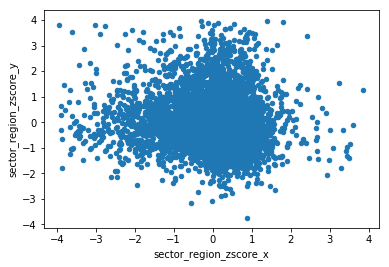

In [9]:
scatter_data[(abs(scatter_data.sector_region_zscore_x) < 4)&(abs(scatter_data.sector_region_zscore_y) < 4)].plot.scatter(x='sector_region_zscore_x',y='sector_region_zscore_y')
#scatter_data.plot.scatter(x='sector_region_zscore_x',y='sector_region_zscore_y')

In [10]:
#scatter_data['x_bins'] = scatter_data[(abs(scatter_data.sector_region_zscore_x) < 4.5)&(abs(scatter_data.sector_region_zscore_y) < 4.5)]['sector_region_zscore_x'].apply(lambda x: round(x,0))
scatter_data['x_bins'] = pd.cut(scatter_data[(abs(scatter_data.sector_region_zscore_x) < 4.5)&(abs(scatter_data.sector_region_zscore_y) < 4.5)]['sector_region_zscore_x'],bins=9,labels=[1,2,3,4,5,6,7,8,9])
mom_val = scatter_data.groupby('x_bins')['sector_region_zscore_y'].median()
#mom_val.plot()